**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
from sklearn.neighbors import KDTree
import scipy

class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        self.k = n_neighbors
        self.algorithm = algorithm
        if metric == 'minkowski':
            self.metric = self.euclidian_pairwise
        else:
            self.metric = self.cosine_pairwise
        
    
    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            self.kdtree = KDTree(X, leaf_size=30)
        else:
            self.X = X
            
        self.y = y
        
        
    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(preds, y)
    
    
    def __popular_in_row(self, row):
        un = np.unique(row, return_counts=True)
        return un[0][np.where(un[1] == un[1].max())[0]][0]
    
    
    def cosine_pairwise(self, X):
        if type(X) is scipy.sparse.csr.csr_matrix:
            norm1 = np.sqrt(scipy.sparse.csr_matrix.sum(self.X.power(2), axis=1)).T
            norm2 = np.sqrt(scipy.sparse.csr_matrix.sum(X.power(2), axis=1))
            return 1 - (((scipy.sparse.csr_matrix.dot(X, self.X.T)) / norm1) / norm2)
        else:
            norm1 = np.sqrt(np.sum(self.X ** 2))[:, np.newaxis]
            norm2 = np.sqrt(np.sum(X ** 2))
            return 1 - (((np.dot(X, self.X.T)) / norm1) / norm2)
        
        
    def euclidian_pairwise(self, X):
        if type(X) is scipy.sparse.csr.csr_matrix:
            dists = -2 * scipy.sparse.csr_matrix.dot(X, self.X.T) + scipy.sparse.csr_matrix.sum(self.X.power(2), axis=1).T + scipy.sparse.csr_matrix.sum(X.power(2), axis=1)
        else:
            dists = np.sqrt(np.sum((X[:, np.newaxis] - self.X) ** 2, axis = 2))
        
        return dists
            
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            pred, y_pred = self.kdtree.query(X, k=self.k)
        else:
            pred = self.metric(X)

            y_pred = np.argsort(pred, axis = 1)[:, 0:self.k]

        ans = np.apply_along_axis(self.__popular_in_row, 1, self.y[y_pred])
            
        return ans
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
print(sklearn_pred)
print(my_clf_pred)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

[0 0 1 2 0 1 0 1 0 1 2 1 2 1 2]
[0 0 1 2 0 1 0 1 0 1 2 1 2 1 2]


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 640 µs, sys: 143 µs, total: 783 µs
Wall time: 684 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.4 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3.07 ms


array([0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.08 ms


array([0, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 979 µs, sys: 210 µs, total: 1.19 ms
Wall time: 1.2 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 151 µs, sys: 33 µs, total: 184 µs
Wall time: 178 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 4.41 ms, sys: 0 ns, total: 4.41 ms
Wall time: 4.04 ms


array([1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 2.31 ms


array([1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
def my_cross_val_score(estimator, X, y, cv):
    sh = X.shape[0] // cv
    scores = list()
    for i in range(cv):
        test_ind = [i for i in range(sh * i, sh * (i + 1))]
        train_ind = [i for i in range(sh * i)] + \
                    [i for i in range(sh * (i + 1), X.shape[0])]
       
        
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        
        estimator.fit(X_train, y_train)
        scores.append(estimator.score(X_test, y_test))
    return scores
        
    
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
print(my_cross_val_score(my_clf, X, target, cv=3))

[0.18801378944577035, 0.19040042429063908, 0.18615751789976134]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

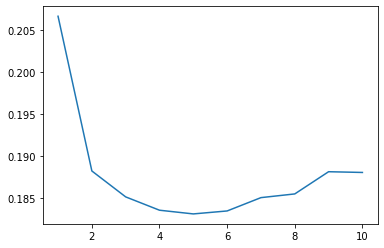

In [24]:
lacc = list()
for i in range(1, 11):
    my_clf = MyKNeighborsClassifier(i, algorithm='brute')
    lacc.append(np.mean(my_cross_val_score(my_clf, X, target, cv=3)))
    
n_neighbors = list(range(1, 11))
plt.plot(n_neighbors, lacc)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

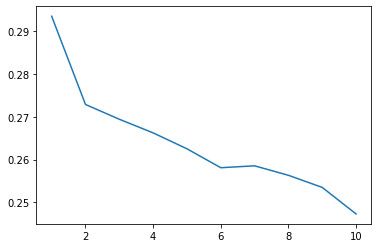

In [25]:
np.seterr(divide='ignore', invalid='ignore')
lacc_cos = list()
for i in range(1, 11):
    my_clf = MyKNeighborsClassifier(i, algorithm='brute', metric='cosine')
    lacc_cos.append(np.mean(my_cross_val_score(my_clf, X, target, cv=3)))
    
n_neighbors = list(range(1, 11))
plt.plot(n_neighbors, lacc_cos)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)

lacc_tfidf = list()
for i in range(1, 11):
    my_clf = MyKNeighborsClassifier(i, algorithm='brute')
    lacc_tfidf.append(np.mean(my_cross_val_score(my_clf, X, target, cv=3)))

lacc_tfidf_cos = list()
for i in range(1, 11):
    my_clf = MyKNeighborsClassifier(i, algorithm='brute', metric='cosine')
    lacc_tfidf_cos.append(np.mean(my_cross_val_score(my_clf, X, target, cv=3)))
    
n_neighbors = list(range(1, 11))

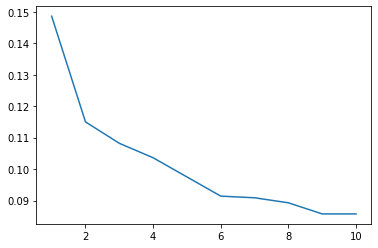

In [27]:
plt.plot(n_neighbors, lacc_tfidf)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

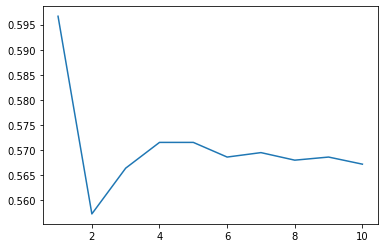

In [28]:
plt.plot(n_neighbors, lacc_tfidf_cos)

In [29]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [30]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(newsgroups['data'])
y_train = newsgroups['target']

newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
X_test = vectorizer.transform(newsgroups['data'])
y_test = newsgroups['target']
my_clf = MyKNeighborsClassifier(1, algorithm='brute', metric='cosine')
my_clf.fit(X_train, y_train)

my_clf.score(X_test, y_test)

0.5088953797132236

Точность получилась меньше, чем на кросс-валидации.
Так могло получиться из-за того, что мы подстраивали гиперпараметры алгоритма под получение лучшей точности на обучающей выборке. 

Конец